# Bias Correction Experiments

In [105]:
import os
import glob
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import seaborn as sns
import tqdm

from cvtk.cov import temporal_cov, calc_deltas
from cvtk.wfsim import wright_fisher, wright_fisher_sample, sample_depth, param_grid

In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 201
#plt.style.use('buffalo.mplstyle')

## Testing missingness handling with simple $N_e$ estimator

Below, we implement two simple $N_e$ estimators:
1. An estimator differences in adjacent frequencies (which return $t-1$ F values for $t$ timepoints, that are later averaged) 
2. An estimator that looks at the total allele frequency change, $p_t - p_0$. 

Both use the same bias correction procedure.

In [113]:
def relative_error(estimate, real):
    return 100. * (real - estimate) / real

In [114]:
def bias_corrected_Ne(freqs, depth, N=None):
    het = freqs*(1-freqs) * depth / (depth - 1) 
    deltas = calc_deltas(freqs)
    covmat = np.cov(deltas) 
    vars = np.diag(covmat)
    vars_corr = vars - (het / depth).mean(axis=1)[:-1] - (het / depth).mean(axis=1)[1:]
    pt_p0 = freqs[-1, :] - freqs[0, :]
    var_pt_p0 = pt_p0.var() - (het / depth).mean(axis=1)[0] - (het / depth).mean(axis=1)[-1]
    mean_het = het.mean(axis=1)
    if N is not None:
        vars_corr += mean_het[:-1] / N
        var_pt_p0 += mean_het[0] / N
    return vars_corr / mean_het[:-1], var_pt_p0 / mean_het[0]

We next step through an example with high N, N=100,000 and high number of loci (L = 1,000,000) and depth (500).

In [147]:
ngens = 10
pop_freqs, sample_freqs, counts, depth = wright_fisher_sample(100000, 1000000, ngens, 500, poisson=True)

Version with Plan II sampling correction:

In [129]:
F_diag, F_diff = bias_corrected_Ne(sample_freqs, depth, N=100000)
print('estimators: ratio of averages V(Δp), average of ratio V(Δp),  V(p_t - p_0)')
print('relative errors: ',
      relative_error(0.5 / F_diag.mean(), 100e3), 
      relative_error((0.5 / F_diag).mean(), 100e3), 
      relative_error((0.5 * ngens) / F_diff, 100e3))
print('Ne estimates: ', 0.5 / F_diag.mean(), (0.5 / F_diag).mean(), (0.5 * ngens) / F_diff)

estimators: ratio of averages V(Δp), average of ratio V(Δp),  V(p_t - p_0)
relative errors:  74.25758809842151 -20.95939029654827 -15.237531927250254
Ne estimates:  25742.411901578496 120959.39029654827 115237.53192725025


Version without Plan II sampling correction:

In [117]:
F_diag, F_diff = bias_corrected_Ne(sample_freqs, depth)
print('estimators: ratio of averages V(Δp), average of ratio V(Δp),  V(p_t - p_0)')
print('relative errors: ',
      relative_error(0.5 / F_diag.mean(), 100e3), 
      relative_error((0.5 / F_diag).mean(), 100e3), 
      relative_error((0.5 * ngens) / F_diff, 100e3))
print('Ne estimates: ', 0.5 / F_diag.mean(), (0.5 / F_diag).mean(), (0.5 * ngens) / F_diff)

estimators: ratio of averages V(Δp), average of ratio V(Δp),  V(p_t - p_0)
relative errors:  18.140603845639127 65.73300500782243 -75.79972840071365
Ne estimates:  81859.39615436087 34266.994992177584 175799.72840071365


In [591]:
grid = param_grid(**dict(
    ngens=[10],
    L=[50000, 100000, 500000],
    poisson=[False],
    rep=np.arange(100), 
    N=[1e2, 1e3, 1e4, 1e5, 1e6],
    depth=[50, 100, 250, 500]))

for params in tqdm.tqdm_notebook(grid):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    sample_covs = temporal_cov(sample_freqs, depths)
    F = np.diag(sample_covs).mean()
    N = params['N']
    params['sample_Ne'] = (0.5 / F).mean()

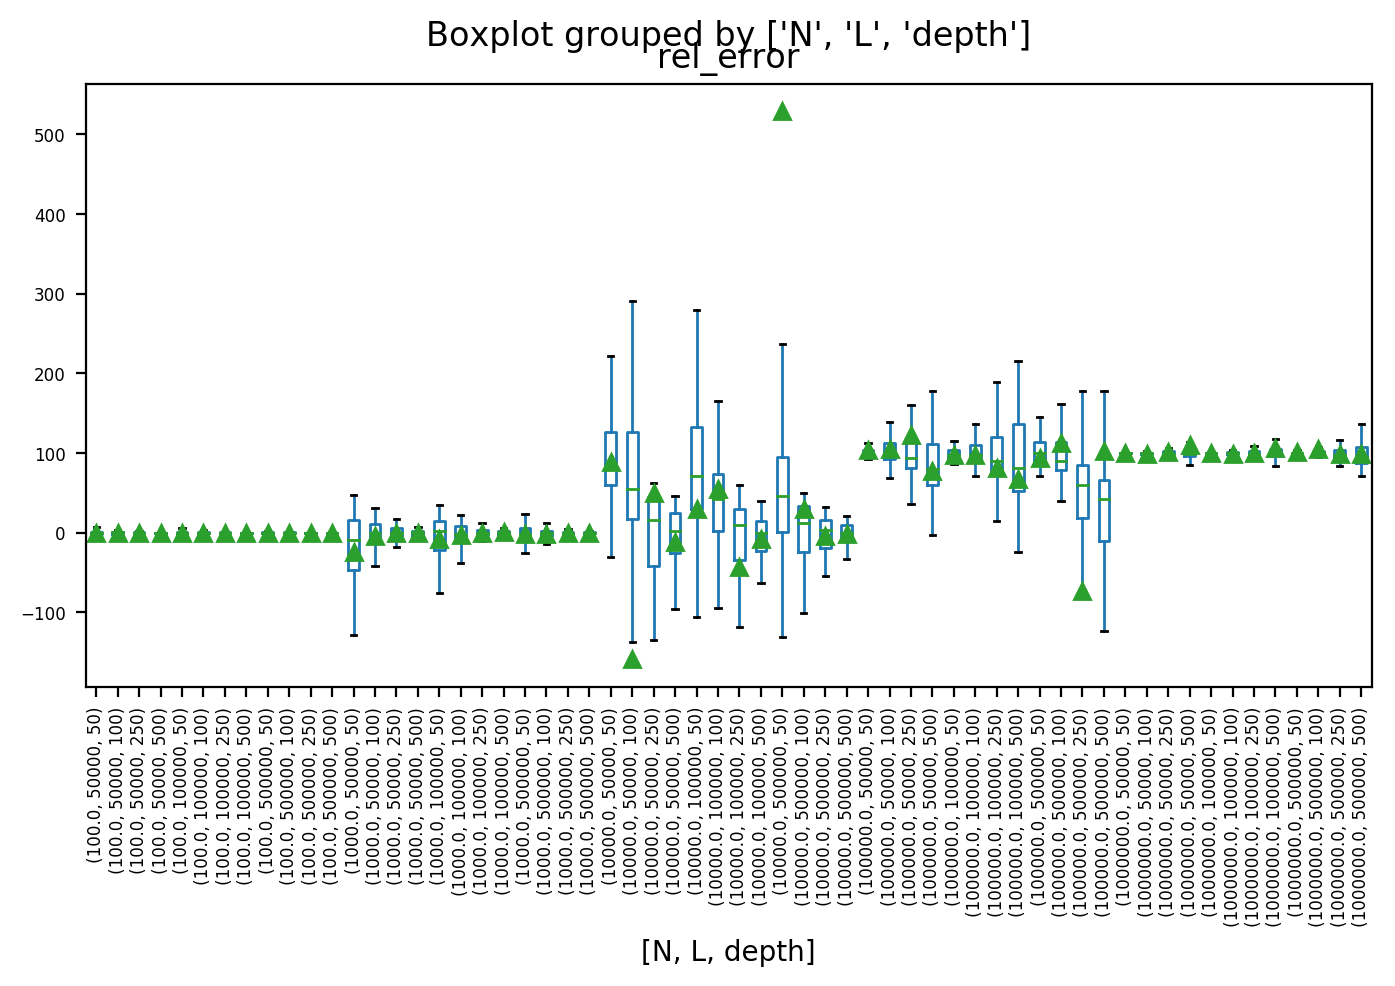

In [593]:

res = pd.DataFrame(grid)
res['rel_error'] = relative_error(res['sample_Ne'].values, res['N'].values)

res.boxplot(column='rel_error', by=['N', 'L', 'depth'], 
                                 showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)

### Without Variable Sampling Depth

In [8]:
grid = param_grid(**dict(
    ngens=[10],
    L=[50000, 100000, 500000],
    poisson=[False],
    rep=np.arange(100), 
    N=[1e2, 1e3, 1e4, 1e5, 1e6],
    depth=[50, 100, 250, 500]))

for params in tqdm.tqdm_notebook(grid):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    F, Ft = bias_corrected_Ne(sample_freqs, depths)
    N = params['N']
    params['Ne_diag_ave_ratio'] = (0.5 / F).mean()
    params['Ne_diag_ratio_ave'] = 0.5 / F.mean()
    params['Ne_pt_p0'] = (params['ngens'] * 0.5) / Ft
    params['rel_error_Ne_diag_ave_ratio'] = relative_error(params['Ne_diag_ave_ratio'], N)
    params['rel_error_Ne_diag_ratio_ave'] = relative_error(params['Ne_diag_ratio_ave'], N)
    params['rel_error_Ne_pt_p0'] = relative_error(params['Ne_pt_p0'], N)

In [22]:
res = pd.DataFrame(grid)
res.to_csv('../data/wf_correction_sims.csv')

### Relative Error of Ne, Ratio of Averages — N ≤ 1000

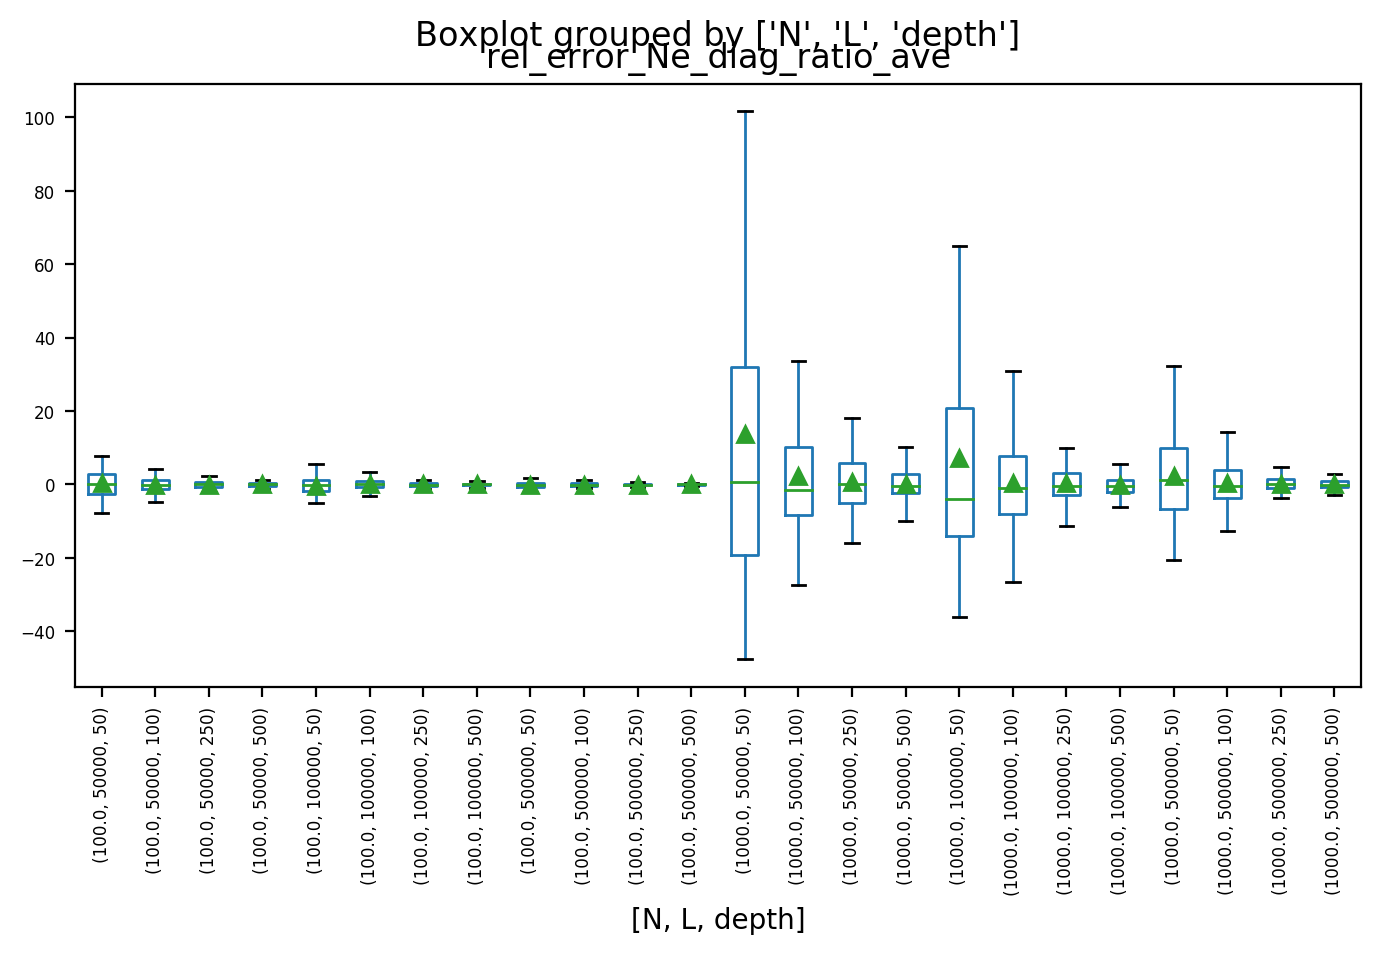

In [59]:
res.loc[res['N'] <= 1e3].boxplot(column='rel_error_Ne_diag_ratio_ave', by=['N', 'L', 'depth'], 
                                 showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)
#plt.ylim((-1e3, 1e3))

### Relative Error of Ne, Ratio of Averages — N > 1000

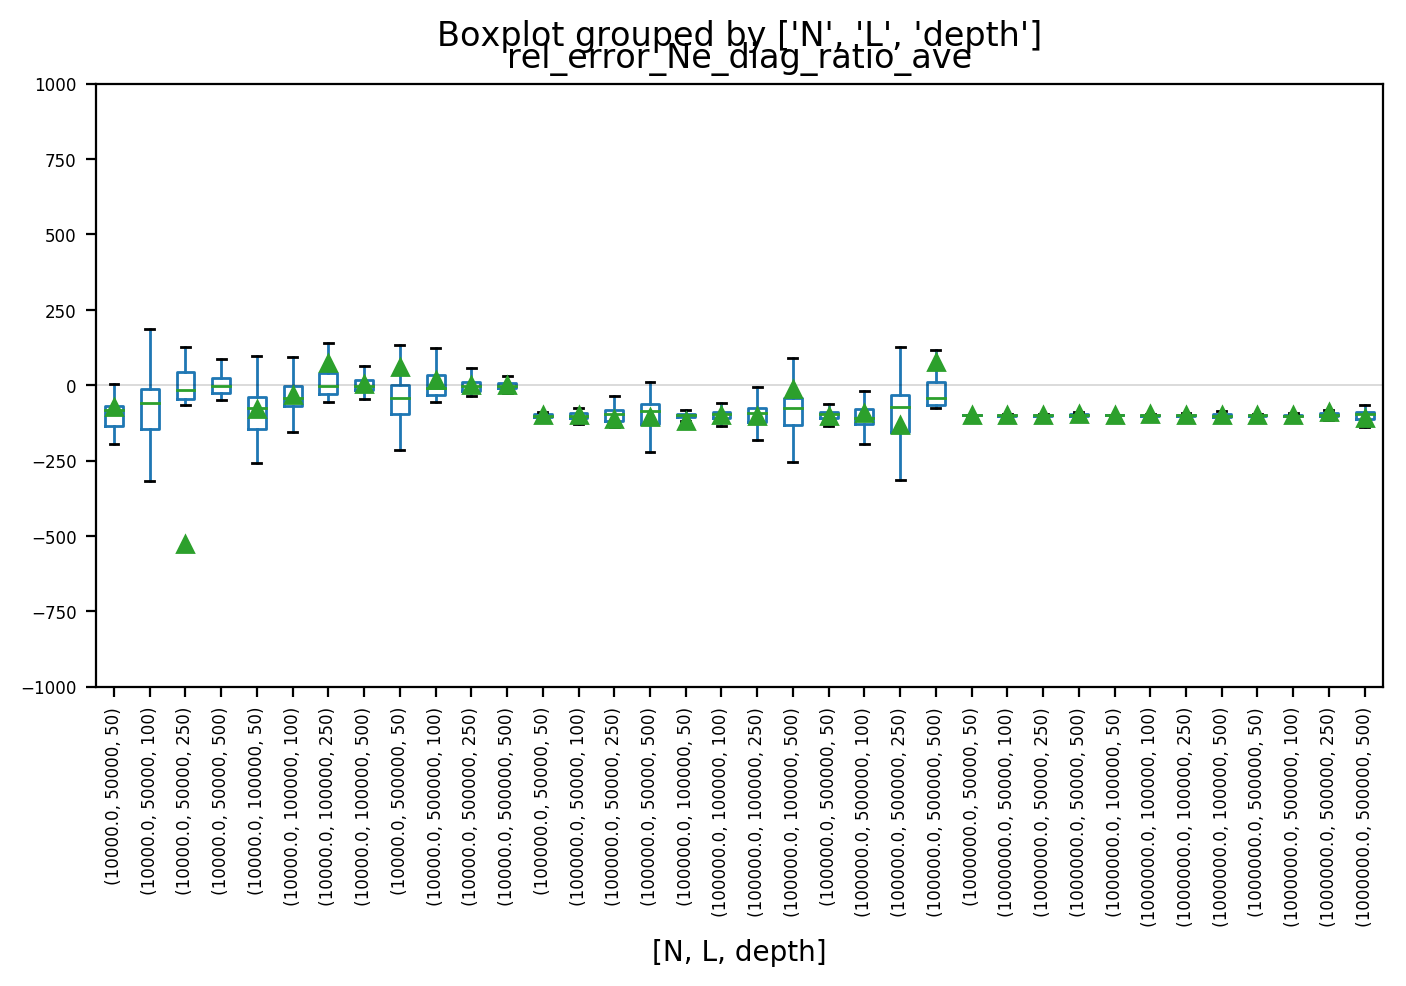

In [126]:
res.loc[res['N'] > 1e3].boxplot(column='rel_error_Ne_diag_ratio_ave', by=['N', 'L', 'depth'], 
                                 showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)
plt.ylim((-1e3, 1e3))
plt.axhline(0, c='k', linewidth=0.1)

### Relative Error of Ne, Average of Ratio

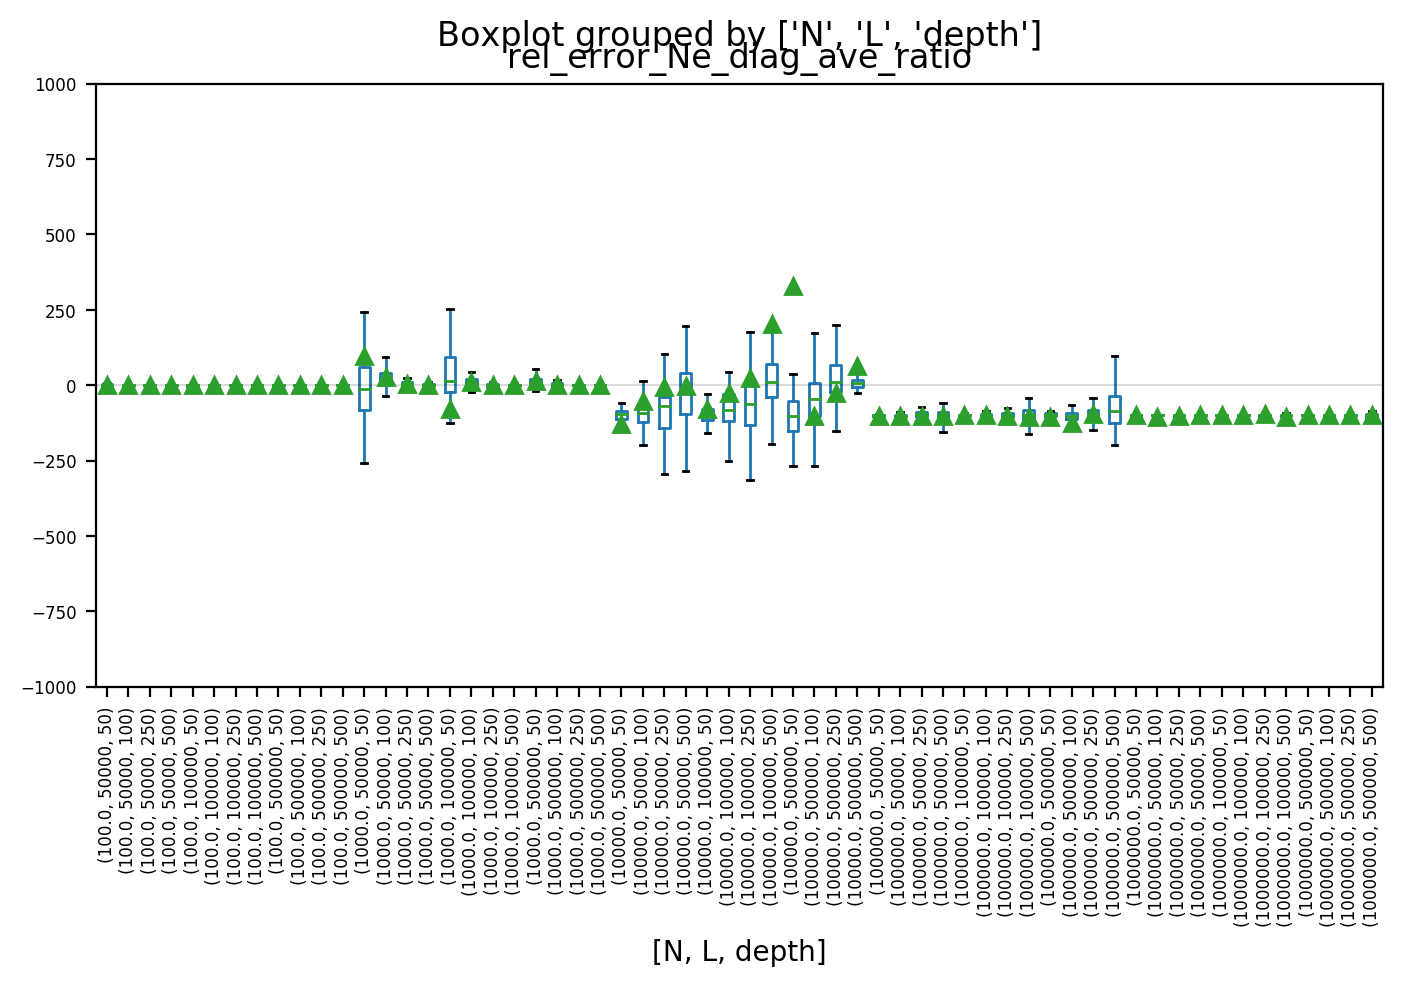

In [123]:
res.boxplot(column='rel_error_Ne_diag_ave_ratio', by=['N', 'L', 'depth'], 
                                showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)
#plt.title('Ne estimator (Average of Ratio) relative error')
plt.ylim((-1e3, 1e3))
plt.axhline(0, c='k', linewidth=0.1)

### Relative Error of Ne, Ratio of Averages

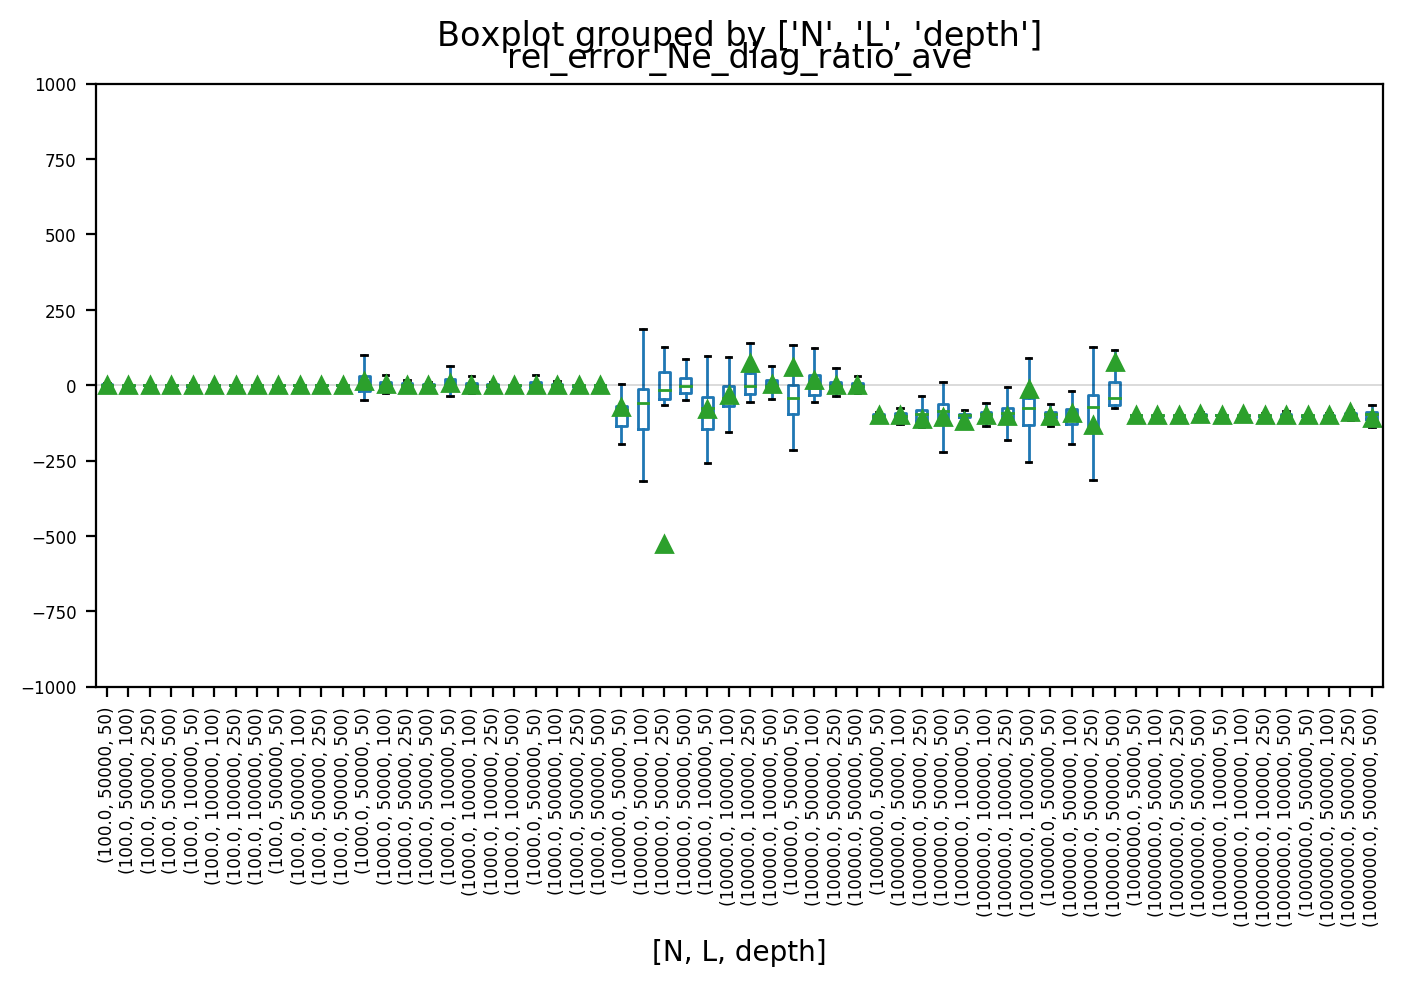

In [112]:
res.boxplot(column='rel_error_Ne_diag_ratio_ave', by=['N', 'L', 'depth'], 
            showmeans=True, grid=False, rot=90, fontsize=6, 
            showfliers=False) 
#plt.title('Ne estimator (Ratio of Averages) relative error')
plt.ylim((-1e3, 1e3))
plt.axhline(0, c='k', linewidth=0.1)

### What's going on around N = 10,000? Does more sampling depth help?

In [153]:
grid_10k = param_grid(**dict(
    ngens=[10],
    L=[100000],
    poisson=[False],
    rep=np.arange(100), 
    N=[1e4],
    depth=[500, 1000, 10000]))

for params in tqdm.tqdm_notebook(grid_10k):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    F, Ft = bias_corrected_Ne(sample_freqs, depths)
    N = params['N']
    params['Ne_diag_ave_ratio'] = (0.5 / F).mean()
    params['Ne_diag_ratio_ave'] = 0.5 / F.mean()
    params['Ne_pt_p0'] = (params['ngens'] * 0.5) / Ft
    params['rel_error_Ne_diag_ave_ratio'] = relative_error(params['Ne_diag_ave_ratio'], N)
    params['rel_error_Ne_diag_ratio_ave'] = relative_error(params['Ne_diag_ratio_ave'], N)
    params['rel_error_Ne_pt_p0'] = relative_error(params['Ne_pt_p0'], N)

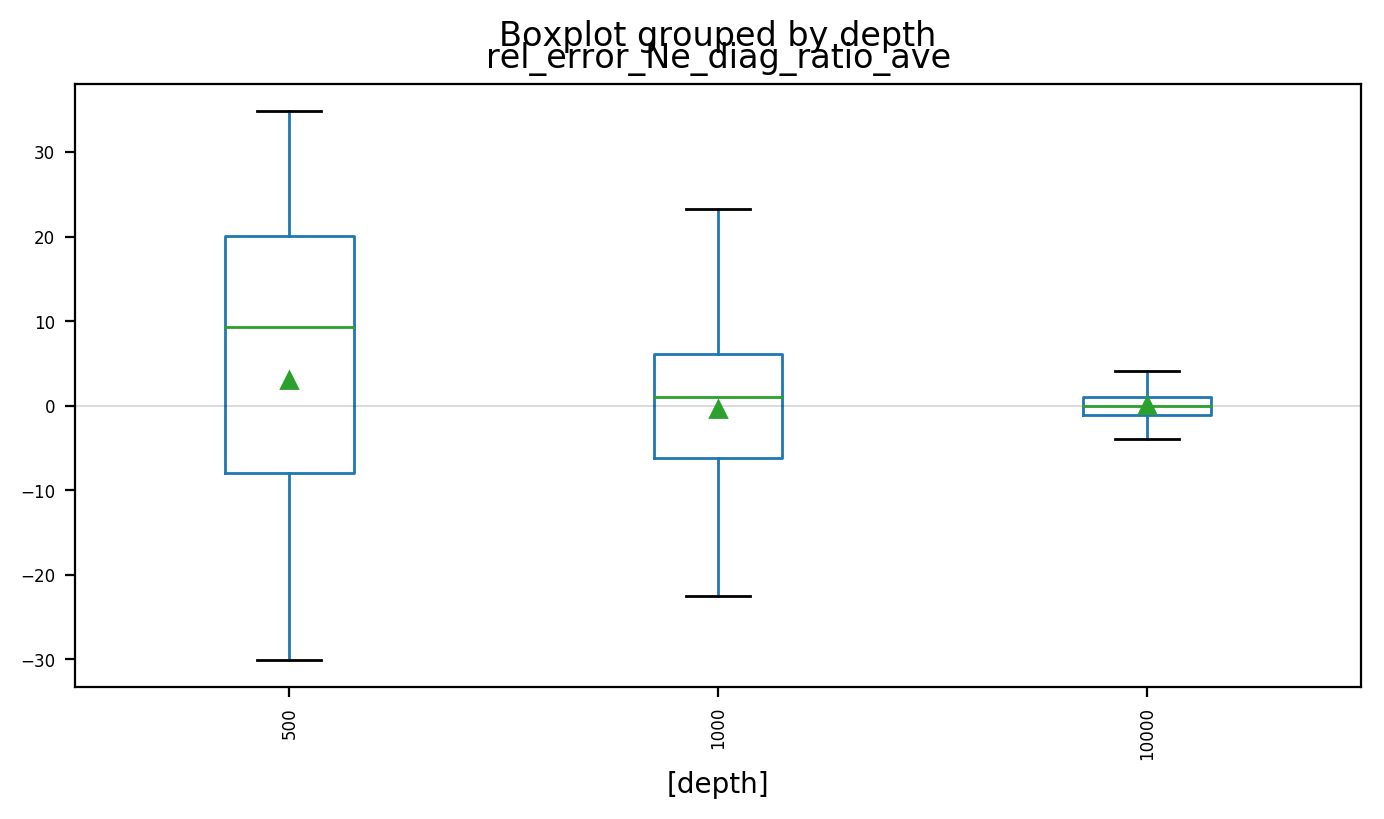

In [157]:
pd.DataFrame(grid_10k).boxplot(column='rel_error_Ne_diag_ratio_ave', by=['depth'],
                               showmeans=True, grid=False, rot=90, fontsize=6,  showfliers=False) 
plt.axhline(0, c='k', linewidth=0.1)

### Does the bias around N = 1,000,000 go away with enough depth?

In [160]:
grid_1M = param_grid(**dict(
    ngens=[10],
    L=[100000],
    poisson=[False, True],
    rep=np.arange(100), 
    N=[1e4],
    depth=[1000, 10000, 100000, 1000000]))

for params in tqdm.tqdm_notebook(grid_1M):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    F, Ft = bias_corrected_Ne(sample_freqs, depths)
    N = params['N']
    params['Ne_diag_ave_ratio'] = (0.5 / F).mean()
    params['Ne_diag_ratio_ave'] = 0.5 / F.mean()
    params['Ne_pt_p0'] = (params['ngens'] * 0.5) / Ft
    params['rel_error_Ne_diag_ave_ratio'] = relative_error(params['Ne_diag_ave_ratio'], N)
    params['rel_error_Ne_diag_ratio_ave'] = relative_error(params['Ne_diag_ratio_ave'], N)
    params['rel_error_Ne_pt_p0'] = relative_error(params['Ne_pt_p0'], N)

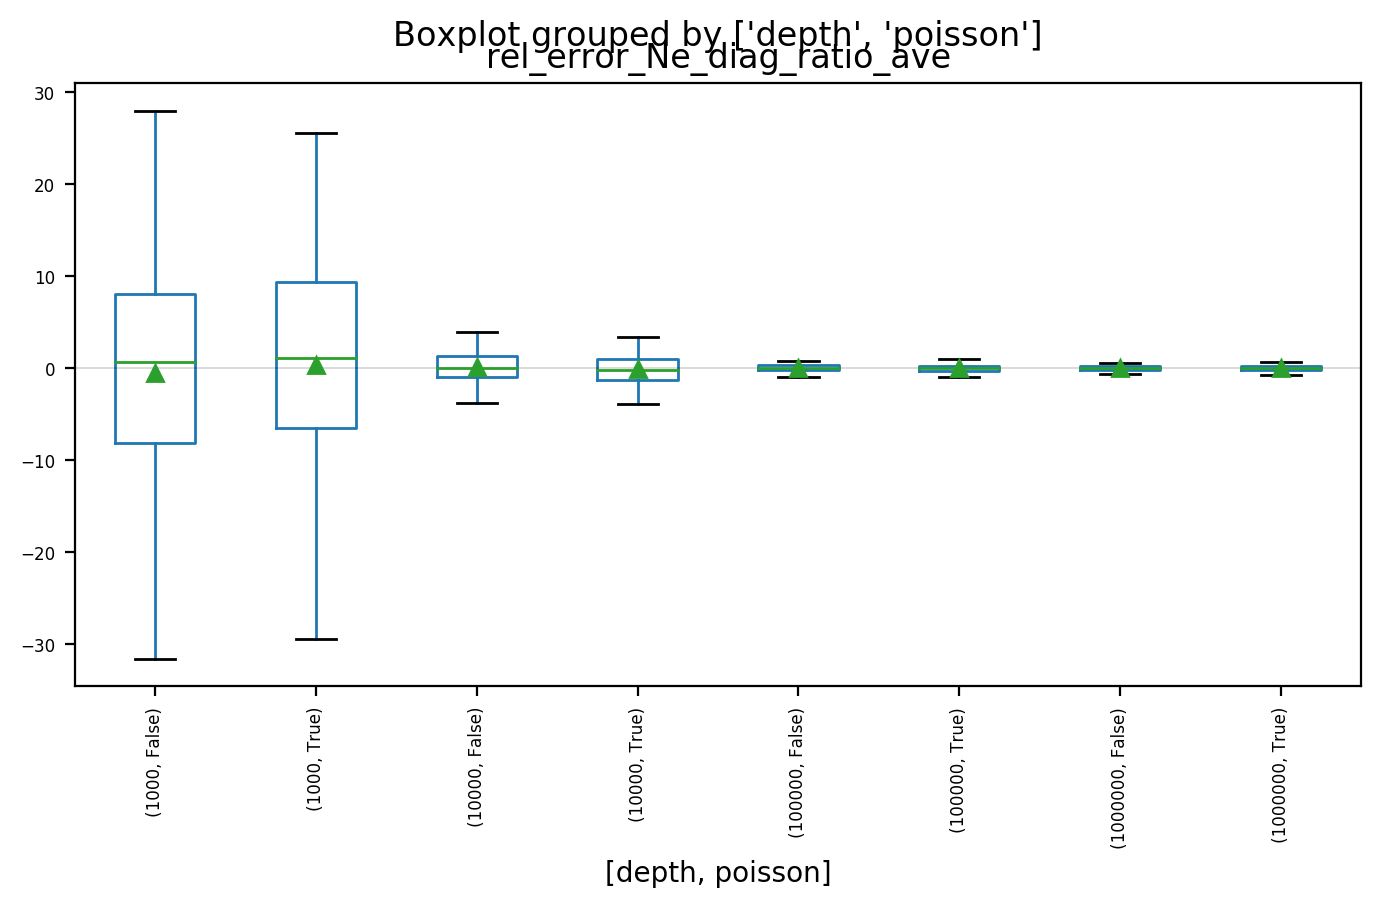

In [162]:
pd.DataFrame(grid_1M).boxplot(column='rel_error_Ne_diag_ratio_ave', by=['depth', 'poisson'],
                               showmeans=True, grid=False, rot=90, fontsize=6,  showfliers=False) 
plt.axhline(0, c='k', linewidth=0.1)

### With Variable Sampling Depth

In [149]:
grid_variable = param_grid(**dict(
    ngens=[10],
    L=[50000, 100000, 500000],
    poisson=[True],
    rep=np.arange(100), 
    N=[1e2, 1e3, 1e4, 1e5, 1e6],
    depth=[50, 100, 250, 500]))

for params in tqdm.tqdm_notebook(grid_variable):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    F, Ft = bias_corrected_Ne(sample_freqs, depths)
    N = params['N']
    params['Ne_diag_ave_ratio'] = (0.5 / F).mean()
    params['Ne_diag_ratio_ave'] = 0.5 / F.mean()
    params['Ne_pt_p0'] = (params['ngens'] * 0.5) / Ft
    params['rel_error_Ne_diag_ave_ratio'] = relative_error(params['Ne_diag_ave_ratio'], N)
    params['rel_error_Ne_diag_ratio_ave'] = relative_error(params['Ne_diag_ratio_ave'], N)
    params['rel_error_Ne_pt_p0'] = relative_error(params['Ne_pt_p0'], N)

In [150]:
res_variable = pd.DataFrame(grid_variable)
res_variable.to_csv('../data/wf_correction_sims_variable_depth.csv')

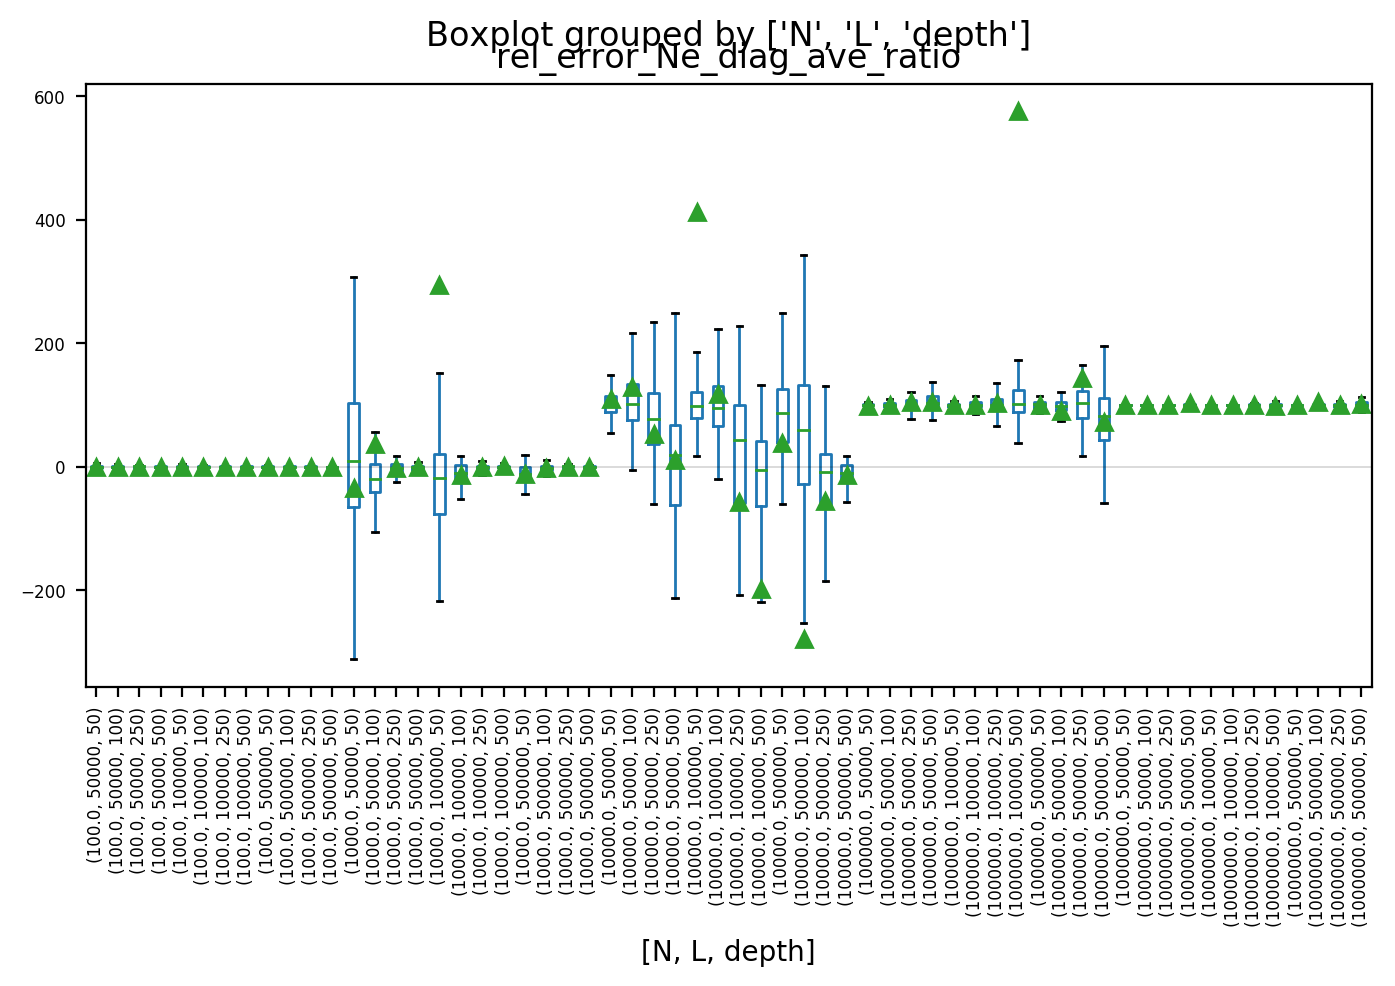

In [401]:
res_variable.boxplot(column='rel_error_Ne_diag_ave_ratio', by=['N', 'L', 'depth'], 
                     showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)
#plt.title('Ne estimator (Average of Ratio) relative error')
#plt.ylim((-1e3, 1e3))
plt.axhline(0, c='k', linewidth=0.1)

## Non-negative Least Squares Approach

In [569]:
ngens = 5
pop_freqs, sample_freqs, counts, depth = wright_fisher_sample(100, 100, ngens, 50, poisson=True)

pop_cov = np.cov(calc_deltas(pop_freqs))
sample_cov = np.cov(calc_deltas(sample_freqs))

In [536]:
pop_cov

array([[ 3.90148990e-04, -4.53813131e-05,  7.68181818e-05,
        -4.41414141e-06],
       [-4.53813131e-05,  4.68835859e-04, -2.29292929e-05,
         9.49292929e-05],
       [ 7.68181818e-05, -2.29292929e-05,  4.54545455e-04,
        -2.13131313e-05],
       [-4.41414141e-06,  9.49292929e-05, -2.13131313e-05,
         3.22464646e-04]])

In [537]:
b = np.concatenate((np.diag(sample_cov), np.diag(sample_cov, k=1)))

In [538]:
from scipy.optimize import nnls

A = np.array([[1, 1, 0, 0, 0], [0, 1, 1, 0, 0], [0, 0, 1, 1, 0], [0, 0, 0, 1, 1], [-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0]])

e1, e2, e3, e4, e5 = nnls(A, b)[0]

In [539]:
print(e1 + e2)
print(e2 + e3)
print(e3 + e4)
print(e4 + e5)
print(e1)
print(e2)

0.003284901604278123
0.002919534338925456
0.00357471479282039
0.0029598499342574484
0.0013845788302886295
0.0019003227739894937


In [540]:
sample_cov - pop_cov

array([[ 0.00287829, -0.00135566,  0.00019796, -0.00057489],
       [-0.00135566,  0.00294515, -0.0013994 , -0.00019942],
       [ 0.00019796, -0.0013994 ,  0.00312017, -0.00050345],
       [-0.00057489, -0.00019942, -0.00050345,  0.00263739]])

In [589]:
ngens = 5
pop_freqs, sample_freqs, counts, depth = wright_fisher_sample(100, 100, ngens, 50, poisson=True)

pop_cov = np.cov(calc_deltas(pop_freqs))
sample_cov = np.cov(calc_deltas(sample_freqs))

def nnls_correction(cov):
    t = cov.shape[0]
    A_rows = []
    for i in range(t):
        row = np.zeros(t+1)
        row[i:(i+2)] = 1
        A_rows.append(row)
    for i in range(t-1):
        row = np.zeros(t+1)
        row[i+1] = -1
        A_rows.append(row)
    A = np.array(A_rows)
    b = np.concatenate((np.diag(cov), np.diag(cov, k=1)))
    e, resids = nnls(A, b)  # estimate the bias vector e
    C = np.zeros((t, t))
    np.fill_diagonal(C, - e[:-1] - e[1:])
    C = C + np.diag(e[1:-1], k=1) + np.diag(e[1:-1], k=-1)
    return cov + C, e, C, resids, A
    

cor_cov, e, errors, resids, A = nnls_correction(sample_cov)
print(cor_cov)
print(pop_cov)
print(sample_cov)
print(np.linalg.norm(cor_cov - pop_cov))
print(np.linalg.norm(sample_cov - pop_cov))

[[ 1.30104261e-18 -7.78080078e-06  5.01488477e-05  7.27705208e-05]
 [-7.78080078e-06 -7.78080078e-06  1.05096922e-04  5.39081949e-04]
 [ 5.01488477e-05  1.05096922e-04  1.12877723e-04  1.12877723e-04]
 [ 7.27705208e-05  5.39081949e-04  1.12877723e-04  0.00000000e+00]]
[[ 4.94169192e-04  4.75025253e-05  7.62121212e-05 -1.92626263e-05]
 [ 4.75025253e-05  2.55886364e-04  5.62626263e-05 -6.41111111e-05]
 [ 7.62121212e-05  5.62626263e-05  4.42929293e-04 -1.36363636e-06]
 [-1.92626263e-05 -6.41111111e-05 -1.36363636e-06  3.83898990e-04]]
[[ 3.84435000e-03 -1.19193117e-03  5.01488477e-05  7.27705208e-05]
 [-1.19193117e-03  3.17930643e-03 -1.89783994e-03  5.39081949e-04]
 [ 5.01488477e-05 -1.89783994e-03  4.25248261e-03 -2.02379030e-03]
 [ 7.27705208e-05  5.39081949e-04 -2.02379030e-03  4.36435392e-03]]
0.0011631864888504591
0.008352403337004507


In [571]:
print(pop_cov - sample_cov)
print(errors)

[[-2.42150760e-03  9.83644136e-04  3.12517746e-05 -2.28200837e-04]
 [ 9.83644136e-04 -3.20611563e-03  1.41973173e-03  2.22265877e-04]
 [ 3.12517746e-05  1.41973173e-03 -2.62879314e-03  1.30129345e-03]
 [-2.28200837e-04  2.22265877e-04  1.30129345e-03 -2.90527624e-03]]
[[-0.00275412  0.00153808  0.          0.        ]
 [ 0.00153808 -0.00327591  0.00173783  0.        ]
 [ 0.          0.00173783 -0.00293842  0.00120058]
 [ 0.          0.          0.00120058 -0.00329795]]


In [572]:
sample_cov

array([[ 2.75412376e-03, -1.10417949e-03, -2.77719766e-05,
         1.77544272e-04],
       [-1.10417949e-03,  3.70981260e-03, -1.31936810e-03,
        -1.62619412e-04],
       [-2.77719766e-05, -1.31936810e-03,  2.92298254e-03,
        -1.21601567e-03],
       [ 1.77544272e-04, -1.62619412e-04, -1.21601567e-03,
         3.29795300e-03]])

In [573]:
print(cor_cov - pop_cov)
print(sample_cov - pop_cov)

[[-3.32616162e-04  5.54434887e-04 -3.12517746e-05  2.28200837e-04]
 [ 5.54434887e-04 -6.97974367e-05  3.18102307e-04 -2.22265877e-04]
 [-3.12517746e-05  3.18102307e-04 -3.09622983e-04 -1.00711367e-04]
 [ 2.28200837e-04 -2.22265877e-04 -1.00711367e-04 -3.92676768e-04]]
[[ 2.42150760e-03 -9.83644136e-04 -3.12517746e-05  2.28200837e-04]
 [-9.83644136e-04  3.20611563e-03 -1.41973173e-03 -2.22265877e-04]
 [-3.12517746e-05 -1.41973173e-03  2.62879314e-03 -1.30129345e-03]
 [ 2.28200837e-04 -2.22265877e-04 -1.30129345e-03  2.90527624e-03]]


In [574]:
# relative error, but this may not be best metric
np.round((cor_cov - pop_cov)/pop_cov, 2)

array([[-1.  , -4.6 , -8.98, -4.5 ],
       [-4.6 , -0.14,  3.17, -3.73],
       [-8.98,  3.17, -1.05, -1.18],
       [-4.5 , -3.73, -1.18, -1.  ]])

In [575]:
def bias_corrected_cov(freqs, depth):
    # this is *not* standardized by heterozygosity
    het = freqs*(1-freqs) * depth / (depth - 1) 
    deltas = calc_deltas(freqs)
    covmat = np.cov(deltas) 
    vars_corr = - np.diag((het / depth).mean(axis=1)[:-1] + (het / depth).mean(axis=1)[1:])
    covs_corr = (het / depth).mean(axis=1)[1:-1]
    covmat_corr = covmat + vars_corr + np.diag(covs_corr, k=1) + np.diag(covs_corr, k=-1)
    #mean_het = het.mean(axis=1)
    return covmat_corr

In [576]:
print(np.linalg.norm(bias_corrected_cov(sample_freqs, depth) - pop_cov))
print(np.linalg.norm(cor_cov - pop_cov))

0.001390611909582281
0.0011865644784130166


In [590]:
bias_norms = []
nnls_norms = []
for i in range(100):
    ngens = 5
    pop_freqs, sample_freqs, counts, depth = wright_fisher_sample(1000, 10000, ngens, 500, poisson=True)

    pop_cov = np.cov(calc_deltas(pop_freqs))
    sample_cov = np.cov(calc_deltas(sample_freqs))
    bias_norms.append(np.linalg.norm(bias_corrected_cov(sample_freqs, depth) - pop_cov))
    nnls_norms.append(np.linalg.norm(cor_cov - pop_cov))

bias_norms = np.array(bias_norms)
nnls_norms = np.array(nnls_norms)
print("bias correction: ", bias_norms.mean())
print("nnls correction: ", nnls_norms.mean())

bias correction:  2.0438709075905566e-05
nnls correction:  0.0008091046985101492


In [556]:
nnls_grid = param_grid(**dict(
    ngens=[10],
    L=[2000],
    poisson=[True],
    rep=np.arange(100), 
    N=[1e2, 1e3, 1e4, 1e5, 1e6],
    depth=[50, 100, 250, 500]))


for params in tqdm.tqdm_notebook(nnls_grid):
    pop_freqs, sample_freqs, counts, depths = wright_fisher_sample(**params)
    fit = nnls_correction(np.cov(calc_deltas(sample_freqs)))
    cor_cov = fit[0]
    het = sample_freqs*(1-sample_freqs) * depths / (depths - 1) 
    mean_het = het.mean(axis=1)
    Ne_est = (0.5) / (np.diag(cor_cov) / mean_het[:-1]).mean()
    params['rel_error_Ne_diag'] = relative_error(Ne_est, N)
    pop_cov = np.cov(calc_deltas(pop_freqs))
    bc_cov = bias_corrected_cov(sample_freqs, depths)
    params['bias_correction_norm'] = np.linalg.norm(bc_cov - pop_cov)
    params['nnls_norm'] = np.linalg.norm(cor_cov - pop_cov)
    params['nnls_neg_var'] = np.sum(np.diag(cor_cov) < 0)
    params['bias_correction_neg_var'] = np.sum(np.diag(bc_cov) < 0)

In [558]:
nnls_summary = pd.DataFrame(nnls_grid).groupby(['L', 'N', 'depth']).mean()
nnls_summary['nnls_better'] = nnls_summary['bias_correction_norm'].values > nnls_summary['nnls_norm'].values
nnls_summary

bias_correction_neg_var  bias_correction_norm  ngens  \
L    N         depth                                                         
2000 100.0     50                        0.04              0.001155   10.0   
               100                       0.00              0.000627   10.0   
               250                       0.00              0.000300   10.0   
               500                       0.00              0.000190   10.0   
     1000.0    50                        3.87              0.000895   10.0   
               100                       2.87              0.000463   10.0   
               250                       1.26              0.000182   10.0   
               500                       0.13              0.000097   10.0   
     10000.0   50                        4.51              0.000795   10.0   
               100                       4.51              0.000388   10.0   
               250                       4.51              0.000153   10.0   
               500                       4.03              0.000079   10.0   
     100000.0  50                        4.29              0.000710   10.0   
               100                       4.59              0.000355   10.0   
               250                       4.78              0.000140   10.0   
               500                       4.81              0.000069   10.0   
     1000000.0 50                        4.52              0.000646   10.0   
               100                       4.65              0.000319   10.0   
               250                       4.54              0.000128   10.0   
               500                       4.37              0.000063   10.0   

                      nnls_neg_var  nnls_norm  poisson  rel_error_Ne_diag  \
L    N         depth                                                        
2000 100.0     50             1.00   0.001530     True          93.889400   
               100            0.54   0.001335     True          94.040402   
               250            0.58   0.001245     True          94.023285   
               500            0.66   0.001234     True          94.022456   
     1000.0    50             3.43   0.000720     True          84.946923   
               100            3.05   0.000380     True          42.707962   
               250            2.10   0.000172     True          40.029582   
               500            1.15   0.000119     True          37.362199   
     10000.0   50             4.02   0.000628     True         457.960313   
               100            3.90   0.000312     True         403.245427   
               250            3.98   0.000123     True         -67.514818   
               500            3.60   0.000065     True         983.691729   
     100000.0  50             4.04   0.000563     True         100.831892   
               100            4.06   0.000275     True        -449.481476   
               250            3.98   0.000110     True         265.206836   
               500            4.23   0.000055     True         292.907737   
     1000000.0 50             4.10   0.000512     True          85.928541   
               100            3.95   0.000257     True        -106.736800   
               250            4.09   0.000102     True         308.631857   
               500            4.05   0.000050     True        -533.067070   

                       rep  nnls_better  
L    N         depth                     
2000 100.0     50     49.5        False  
               100    49.5        False  
               250    49.5        False  
               500    49.5        False  
     1000.0    50     49.5         True  
               100    49.5         True  
               250    49.5         True  
               500    49.5        False  
     10000.0   50     49.5         True  
               100    49.5         True  
               250    49.5         True  
               500    49.5         True  
     100000.0  50     

(-300, 600)

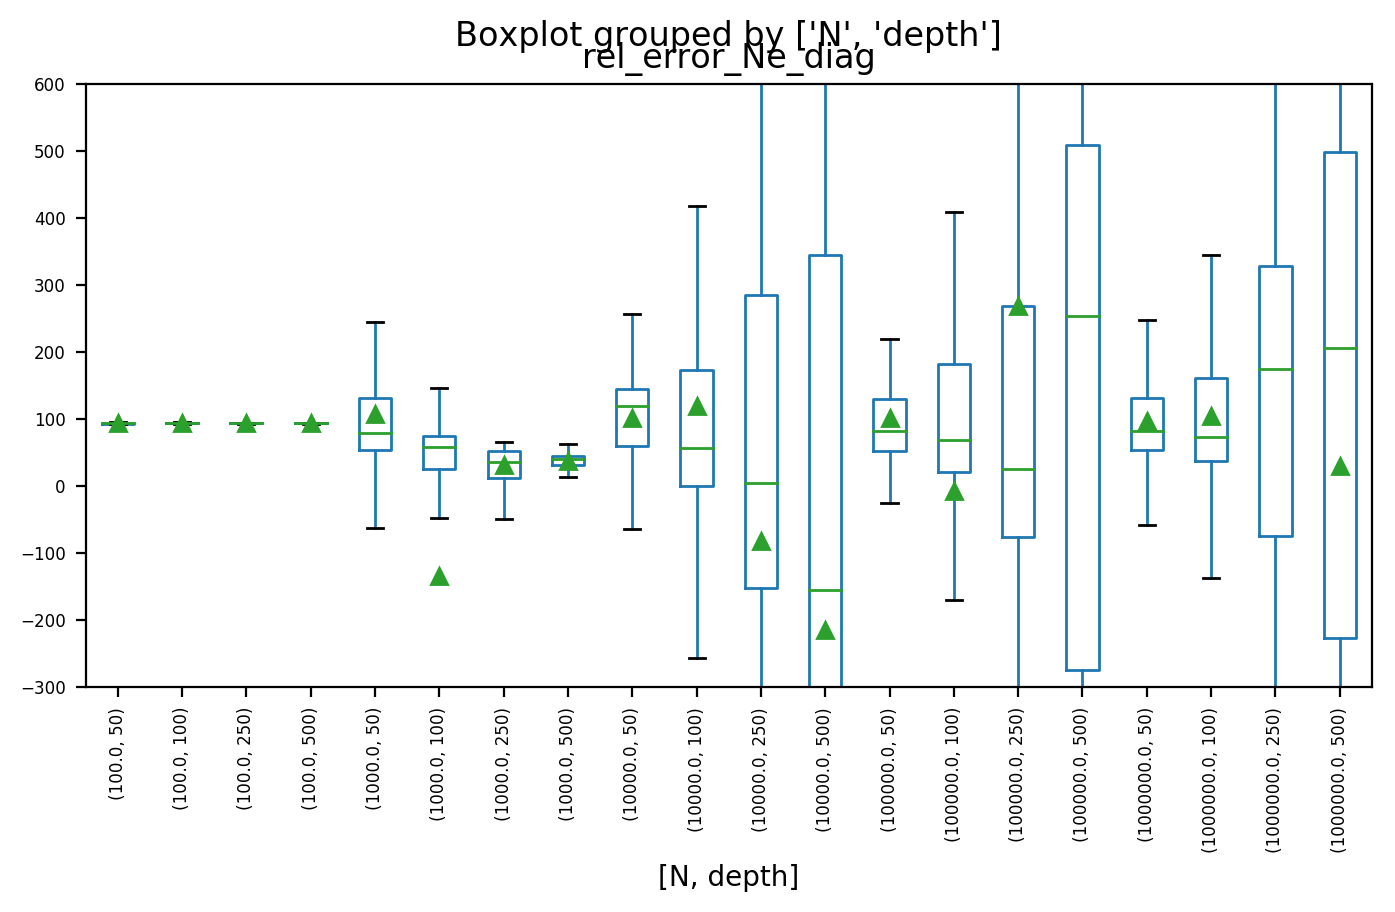

In [509]:
pd.DataFrame(nnls_grid).boxplot('rel_error_Ne_diag', by=['N', 'depth'], showmeans=True, grid=False, rot=90, fontsize=6, showfliers=False)
plt.ylim(-300, 600)

### Tests

In [24]:
def param_grid(**params):
    keys, values = zip(*params.items())
    return [dict(zip(keys, vals)) for vals in itertools.product(*values)]

def mean_diag(covs, k=0):
    return np.nanmean(np.diag(covs, k=k))

grid = param_grid(N=[100, 1000, 10e3, 10e4], 
                  L=[500, 1000, 2000],
                  ngens=[10], 
                  depth=[20, 50, 100, 500], 
                  #diploids=[0],
                  rep=range(100), 
                  poisson=[False],
                  weighted=[False],
                  center=[True])

for params in grid:
    if params['weighted'] and params['center']:
        # not feasible combination, ignore
        continue
    freqs, sample_freqs, counts, depth = wright_fisher_sample(**params)
    #diploids = params['diploids'] if params['diploids'] != 0 else None
    sample_covmat = temporal_cov(sample_freqs, depths=depth, diploids=None, weighted=params['weighted'], center=params['center'])
    covmat = temporal_cov(freqs, center=params['center'])
    params['sample_freqs'] = sample_freqs
    params['counts'] = counts
    params['depth'] = depth
    params['covmat'] = covmat
    params['sample_covmat'] = sample_covmat
    params['uncorrected_sample_covmat'] = np.cov(calc_deltas(sample_freqs[np.newaxis, ...])[0, ...])
    params['offdiag'] = np.nanmean(np.diag(covmat, k=1))
    params['diag'] = np.nanmean(np.diag(covmat))
    params['sample_offdiag'] = np.nanmean(np.diag(sample_covmat, k=1))
    params['sample_diag'] = np.nanmean(np.diag(sample_covmat))

KeyboardInterrupt: 

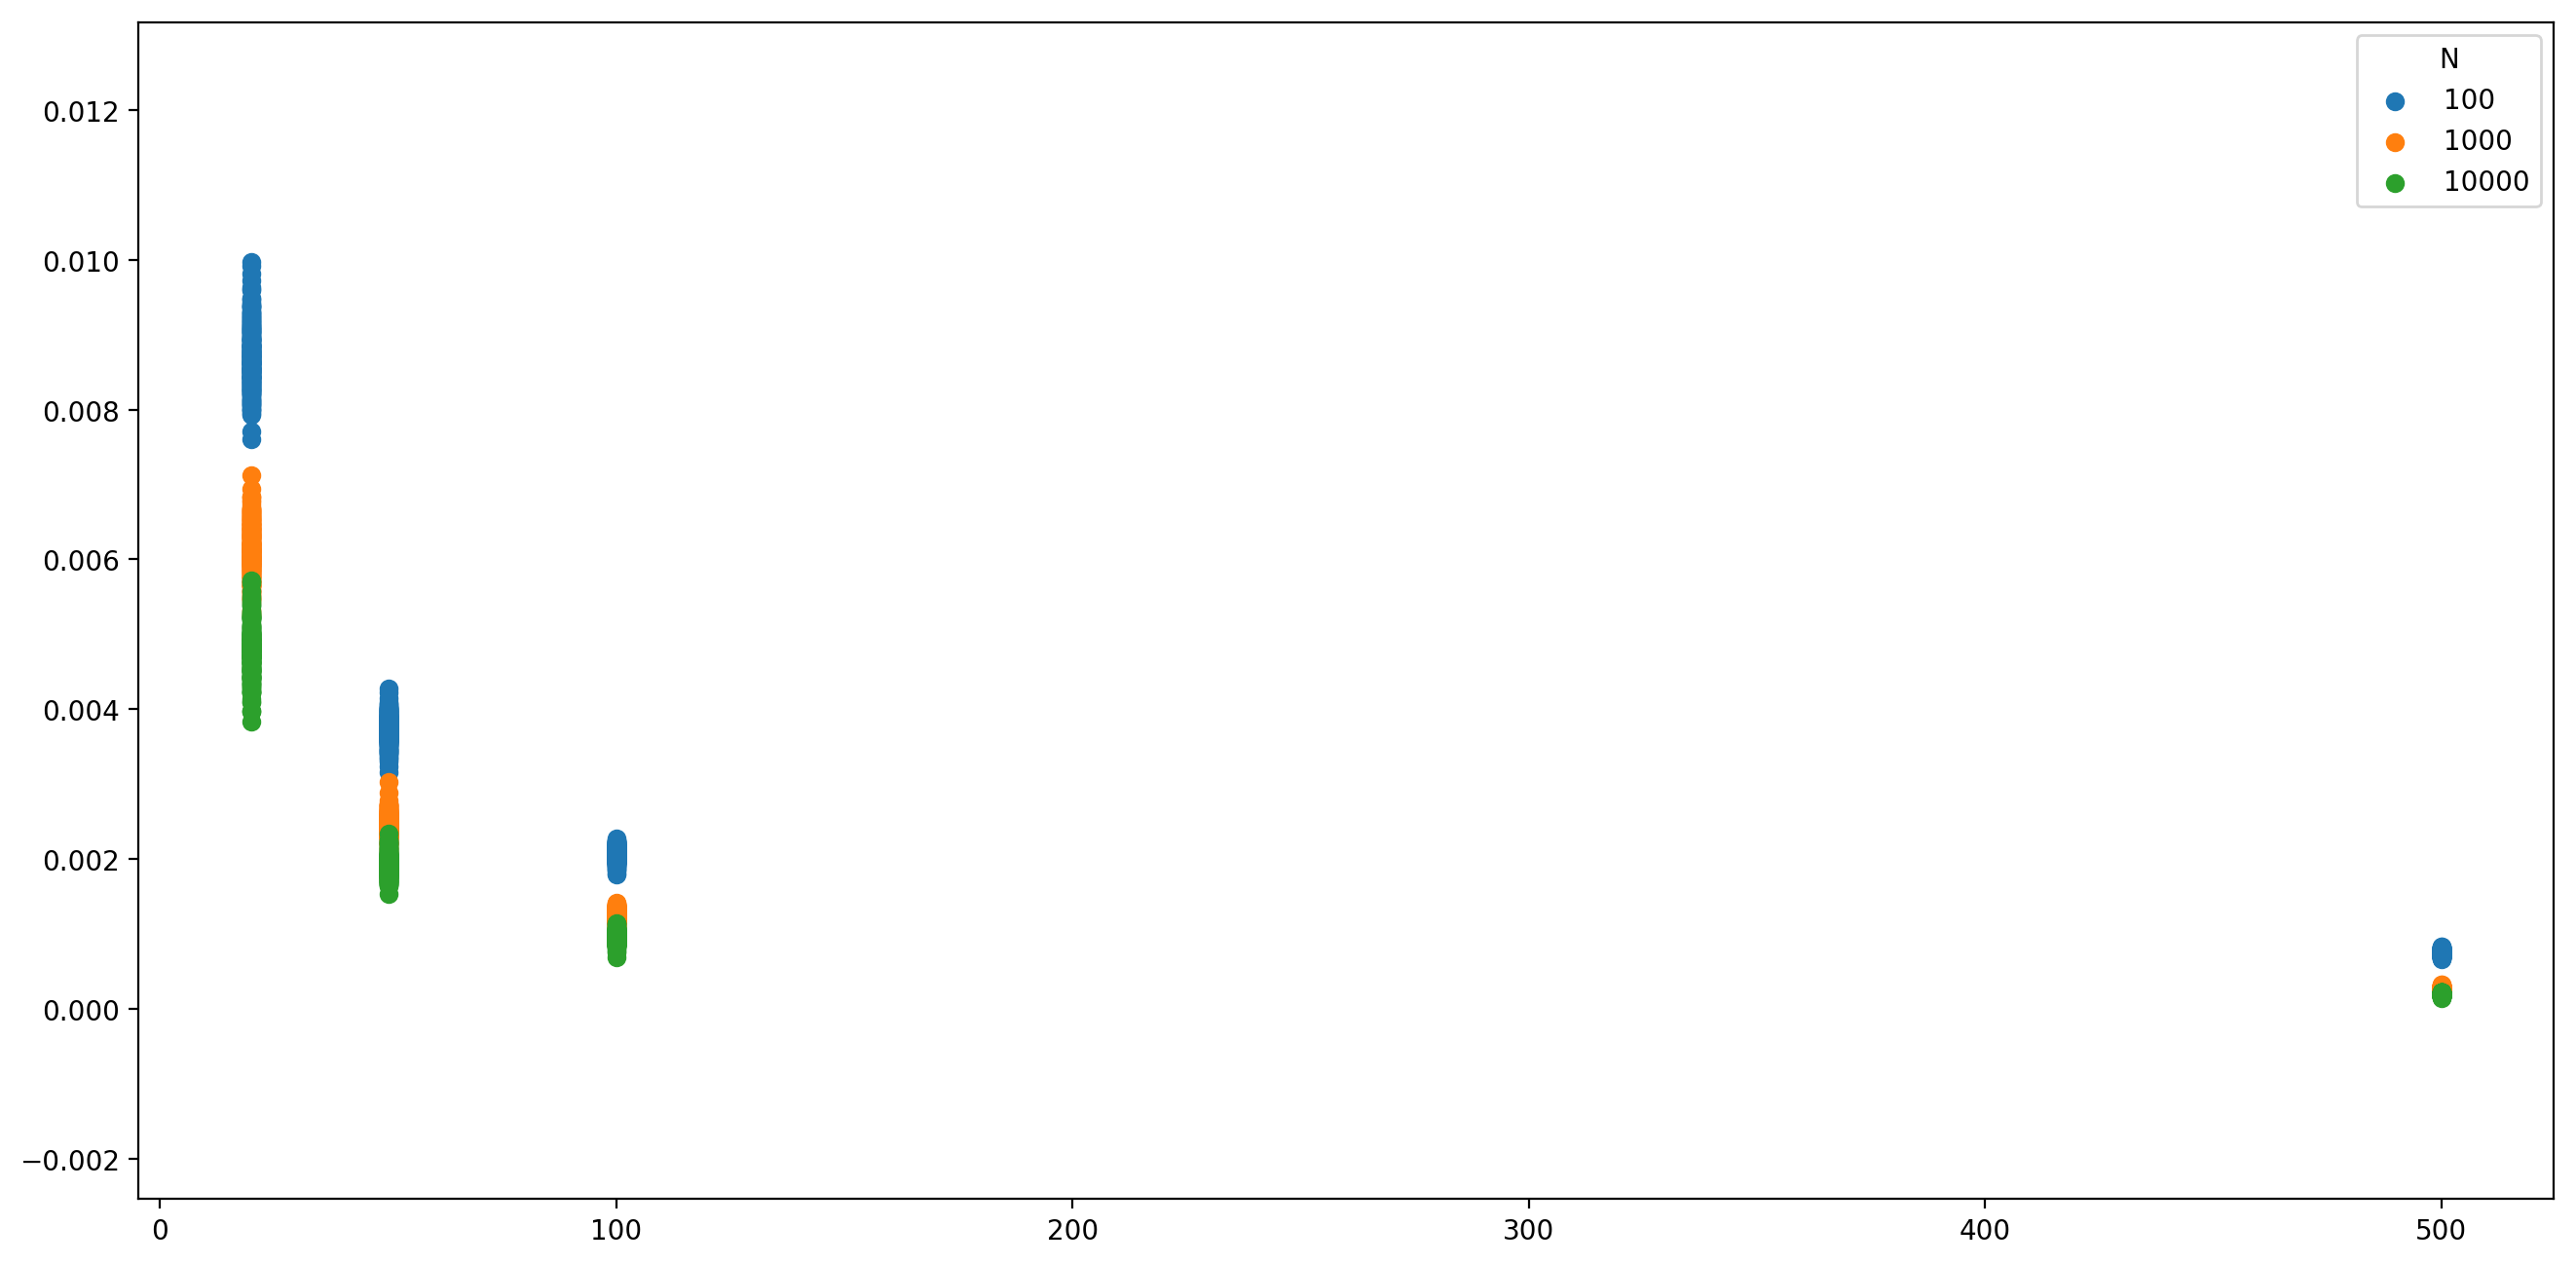

In [23]:
# Looking at noise  variation for N=1000
d100 = np.array([(x['depth'].mean(), np.diag(x['uncorrected_sample_covmat']).mean()) for x in grid if x['N'] == 100])
d1k = np.array([(x['depth'].mean(), np.diag(x['uncorrected_sample_covmat']).mean()) for x in grid if x['N'] == 1000])
d10k = np.array([(x['depth'].mean(), np.diag(x['uncorrected_sample_covmat']).mean()) for x in grid if x['N'] == 10000])
plt.scatter(d100[:, 0], d100[:, 1])
plt.scatter(d1k[:, 0], d1k[:, 1])
plt.scatter(d10k[:, 0], d10k[:, 1])
plt.legend([100, 1000, 10000], title='N')

In [199]:
stats = pd.DataFrame(grid)
#res = stats.groupby(['L', 'N', 'center', 'depth', 'ngens', 'poisson', 'diploids', 'weighted']).mean().reset_index()

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


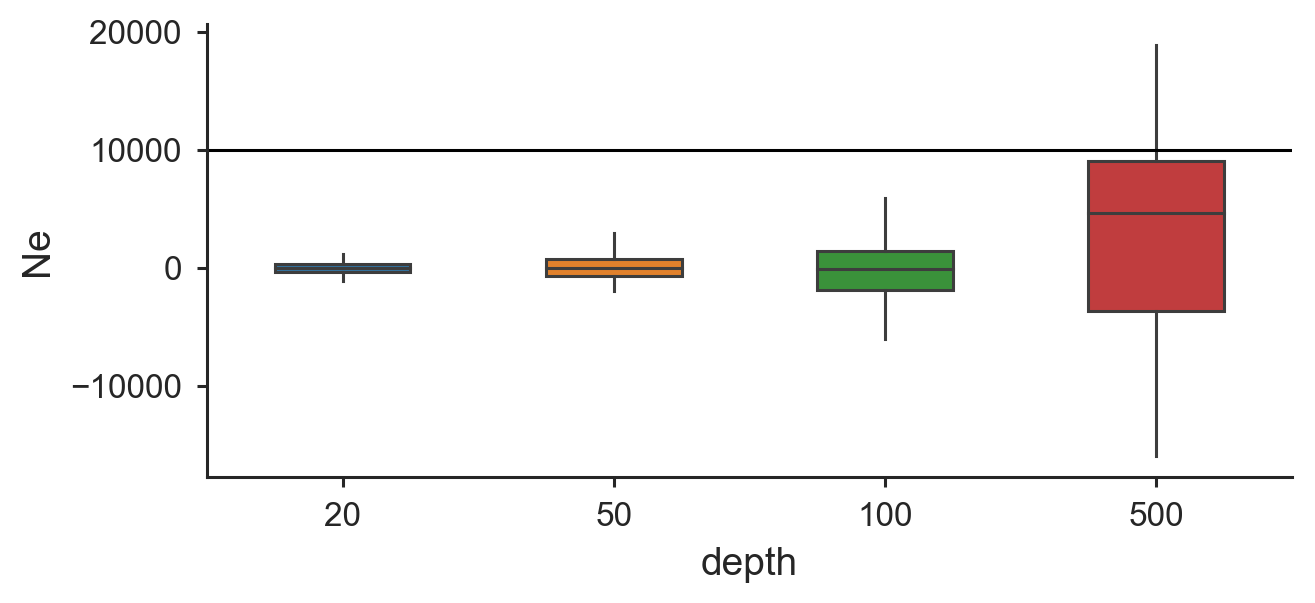

In [239]:
plt.style.use('buffalo.mplstyle')
N =10e3
fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 2000) & (stats['N'] == N)]
d['Ne'] = 0.5 / d[['sample_diag']].values
sns.boxplot(x='depth', y='Ne', data=d, width=.5)
plt.axhline(N, c='k')

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


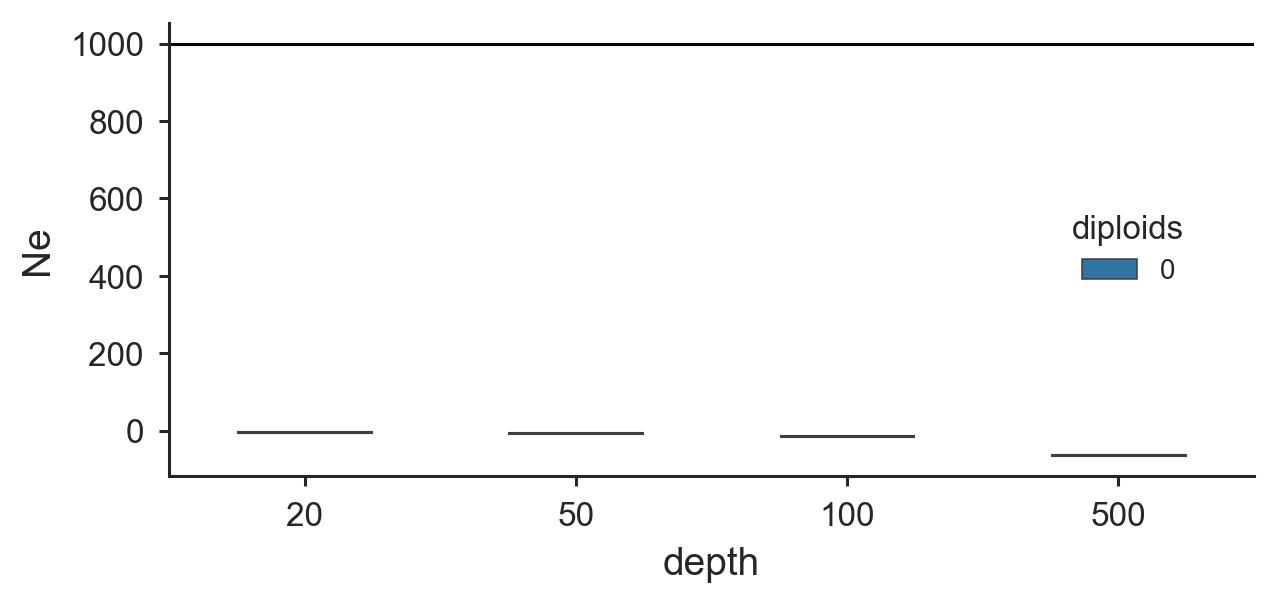

In [127]:
plt.style.use('buffalo.mplstyle')

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 2000) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 0)]
d['Ne'] = 0.5 / d[['sample_diag']].values
sns.boxplot(x='depth', y='Ne', hue='diploids', data=d, width=.5)
plt.axhline(1000, c='k')

ValueError: Could not interpret input 'diag_bias'

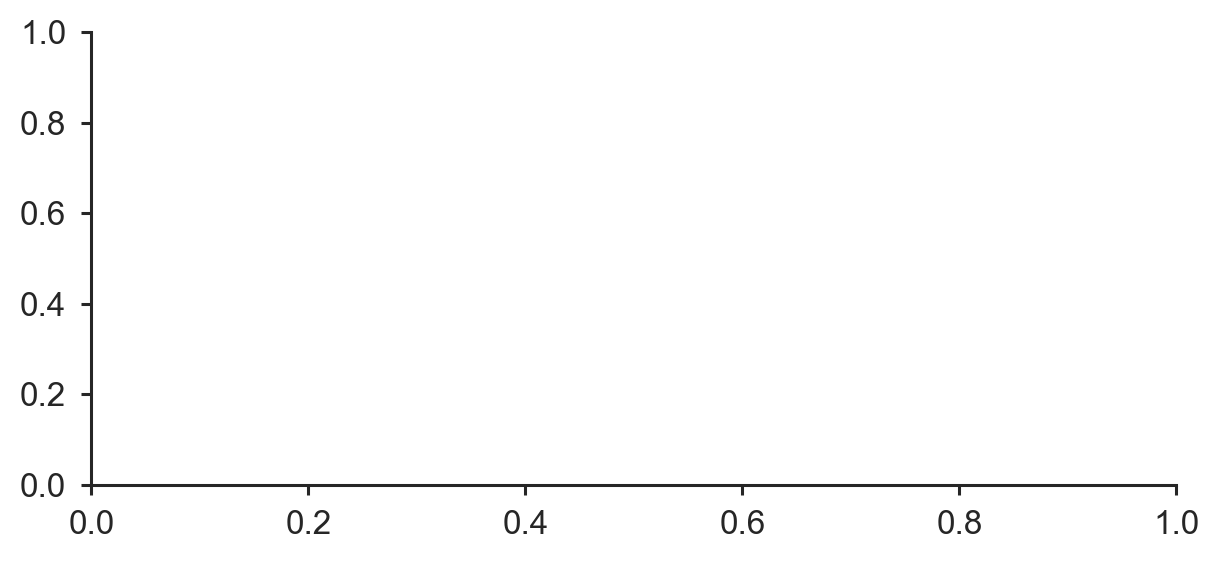

In [74]:
plt.style.use('buffalo.mplstyle')

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 0)]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='center', data=d, width=.5)
#plt.boxplot()
plt.axhline(0, c='k')

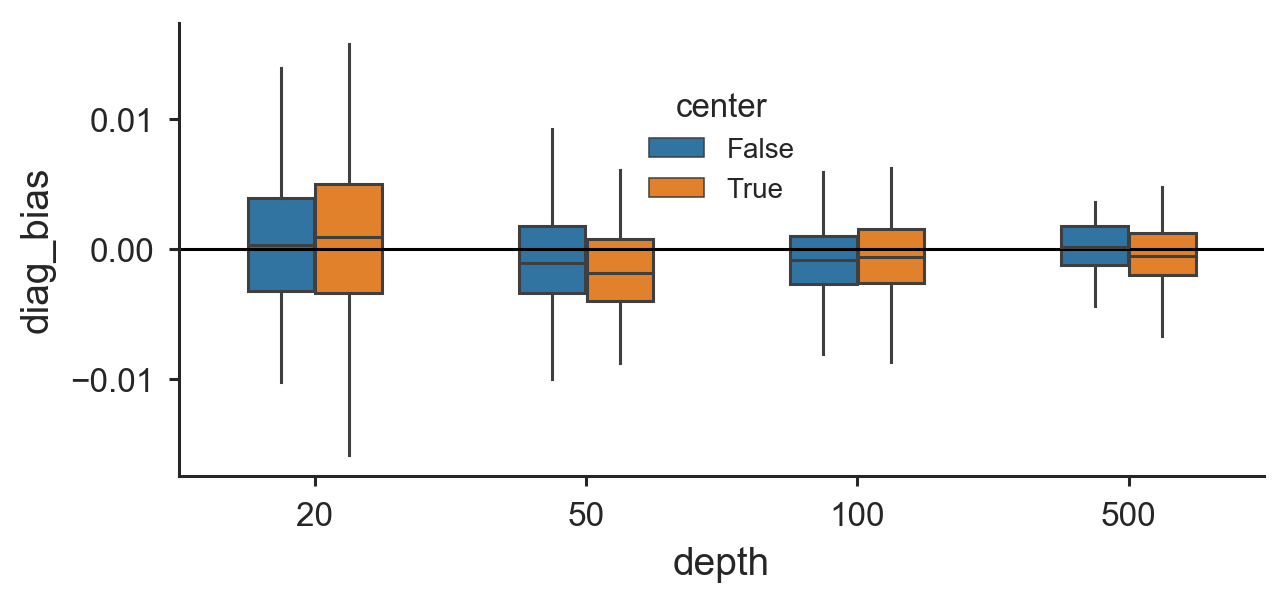

In [44]:
fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 10)]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='center', data=d, width=.5)
#plt.boxplot()
plt.axhline(0, c='k')

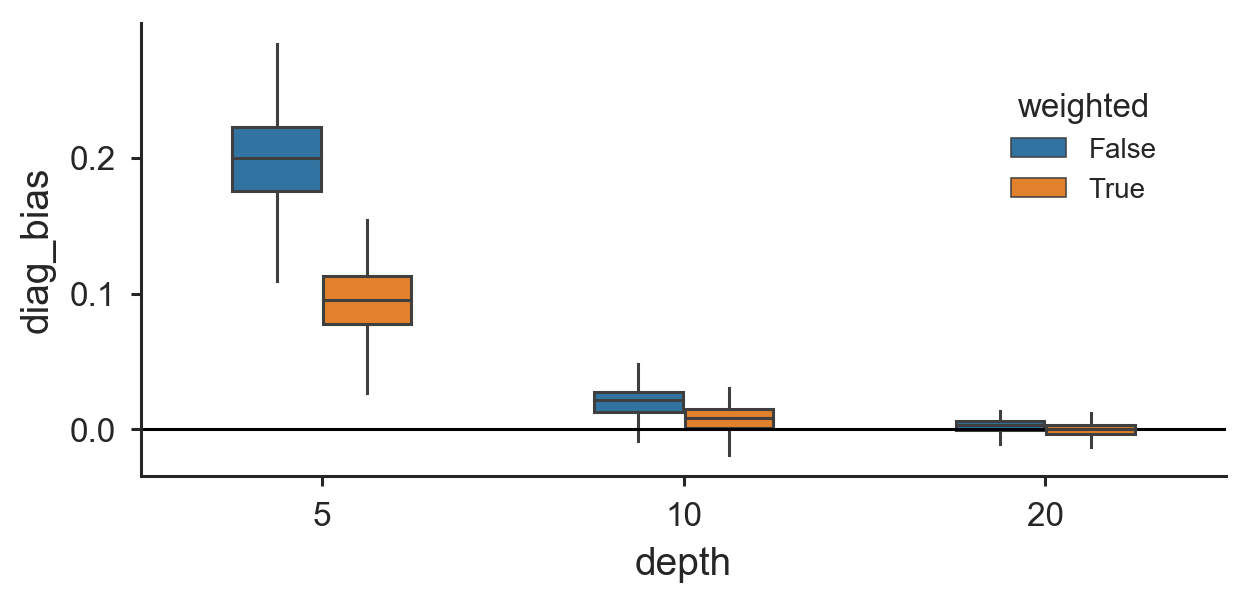

In [21]:
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['depth'] <= 20) & (stats['poisson'])]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')

fig, ax = plt.subplots(figsize=(7, 3))
sns.boxplot(x='depth', y='diag_bias', hue='weighted', data=d, width=0.5)
plt.axhline(0, c='k')

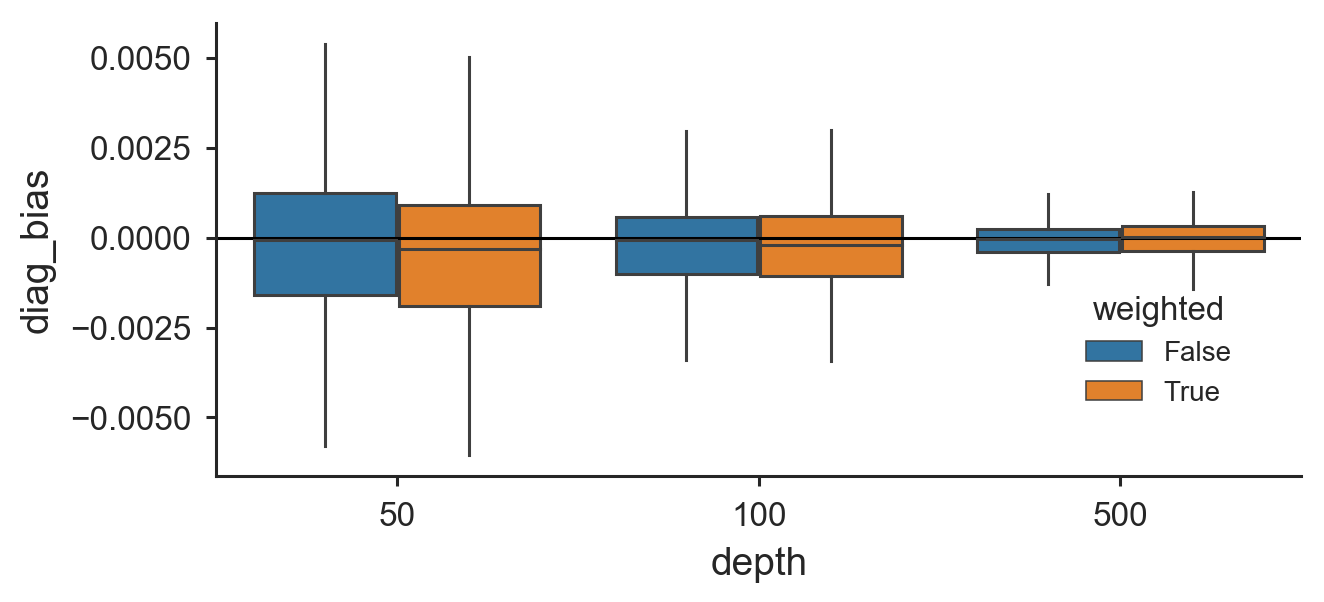

In [22]:

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['depth'] > 20) & (stats['poisson'])]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='weighted', data=d)
plt.axhline(0, c='k')